In [63]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pooch
import os
import tempfile
import pandas as pd
import s3fs
import boto3
import botocore
import datetime
# imports for visual
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from pythia_datasets import DATASETS
import geoviews as gv
import geoviews.feature as gf

In [64]:
# @title Helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/Precipitation' # this is different for each day
    user_temp_cache=tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

In [65]:
# code to retrieve and load the data

years = range(1981,2024) 
file_paths = ['https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/chirps-v2.0.' + str(year) + '.days_p25.nc' for year in years] # the format of the files
filenames = ['chirps-v2.0.'+str(year)+'.days_p25.nc' for year in years] # the format of the files

downloaded_files=[ pooch_load(fpath,fname) for (fpath,fname) in zip(file_paths,filenames)] # download all of the files

#### open data via xarray
chirps_data = xr.open_mfdataset(
    downloaded_files, combine="by_coords"
)  # open the files as one dataset


In [66]:
# code to print the shape, array names, etc of the dataset
chirps_data

<xarray.Dataset> Size: 36GB
Dimensions:    (time: 15491, latitude: 400, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 2kB -49.88 -49.62 -49.38 ... 49.38 49.62 49.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 124kB 1981-01-01 1981-01-02 ... 2023-05-31
Data variables:
    precip     (time, latitude, longitude) float32 36GB dask.array<chunksize=(61, 67, 240), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-10-07
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [67]:
# Define the region of interest (e.g., bounding box)
lat_min, lat_max = 0.10, 8.57  # Latitude bounds
lon_min, lon_max = -1.8433, 12.1416  # Longitude bounds

dry_season = [11,12,1,2,3]
# Define the time range (e.g., single time slice or a range)
jjas = chirps_data.time.dt.month.isin(range(6, 10))#wet season
ndjfm = chirps_data.time.dt.month.isin(dry_season)#dry season

#time_range = slice("1981-01-01", "2023-05-31") 

# Subset the data
subset_data_wet = chirps_data.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), time=jjas)

subset_data_dry = chirps_data.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), time=ndjfm)

subset_data_dry
#gulf_data_wet_season = subset_data_wet.mean(dim ='time')

#gulf_data_dry_season = subset_data_dry.mean(dim ='time') 



#Top Left Corner: Latitude 8.5706, Longitude -1.8433
#Bottom Right Corner: Latitude 0.1078, Longitude 12.1416


<xarray.Dataset> Size: 49MB
Dimensions:    (time: 6442, latitude: 34, longitude: 56)
Coordinates:
  * latitude   (latitude) float32 136B 0.125 0.375 0.625 ... 7.875 8.125 8.375
  * longitude  (longitude) float32 224B -1.625 -1.375 -1.125 ... 11.88 12.12
  * time       (time) datetime64[ns] 52kB 1981-01-01 1981-01-02 ... 2023-03-31
Data variables:
    precip     (time, latitude, longitude) float32 49MB dask.array<chunksize=(61, 1, 7), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-10-07
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [68]:
#SLicing for 
ndjfm = chirps_data.time.dt.month.isin(range(11, 4))
ndjfm
clim = chirps_data.sel(time=ndjfm)#.mean("time")
clim

<xarray.Dataset> Size: 7kB
Dimensions:    (time: 0, latitude: 400, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 2kB -49.88 -49.62 -49.38 ... 49.38 49.62 49.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 0B 
Data variables:
    precip     (time, latitude, longitude) float32 0B dask.array<chunksize=(0, 67, 240), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-10-07
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [69]:
gulf_data

<xarray.Dataset> Size: 8kB
Dimensions:    (latitude: 34, longitude: 56)
Coordinates:
  * latitude   (latitude) float32 136B 0.125 0.375 0.625 ... 7.875 8.125 8.375
  * longitude  (longitude) float32 224B -1.625 -1.375 -1.125 ... 11.88 12.12
Data variables:
    precip     (latitude, longitude) float32 8kB dask.array<chunksize=(1, 7), meta=np.ndarray>

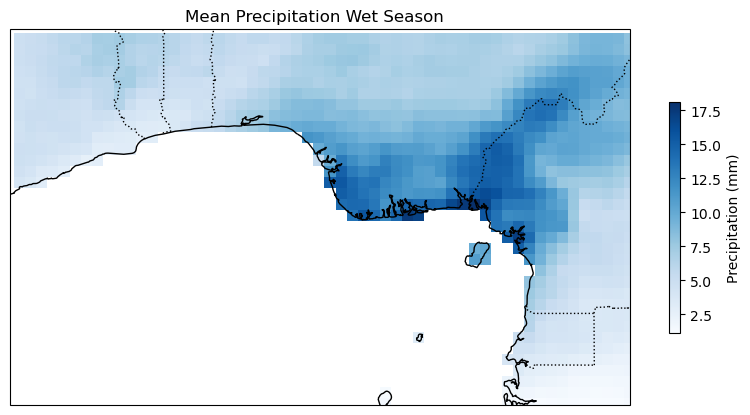

<Figure size 640x480 with 0 Axes>

In [88]:
mean_precipitation_wet = subset_data_wet['precip'].mean(dim='time')

# Create a plot
plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Add features to the plot
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the precipitation data
precip_plot_wet = ax.pcolormesh(subset_data_wet['longitude'], subset_data['latitude'], mean_precipitation_wet, cmap='Blues', shading='auto')
#precip_plot_dry = ax.pcolormesh(subset_data_dry['longitude'], subset_data['latitude'], mean_precipitation_dry, cmap='Blues', shading='auto')

# Add a colorbar

cbar = plt.colorbar(precip_plot_wet, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Precipitation (mm)')

# Add title and labels
ax.set_title('Mean Precipitation Wet Season  ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#fig.colorbar(precip_plot_dry, ax=ax)

# Show the plot
plt.show()

plt.savefig('Wetseason', format='jpg', dpi=300)

#MEAN PRECIPITAITON FOR DRY SEASON

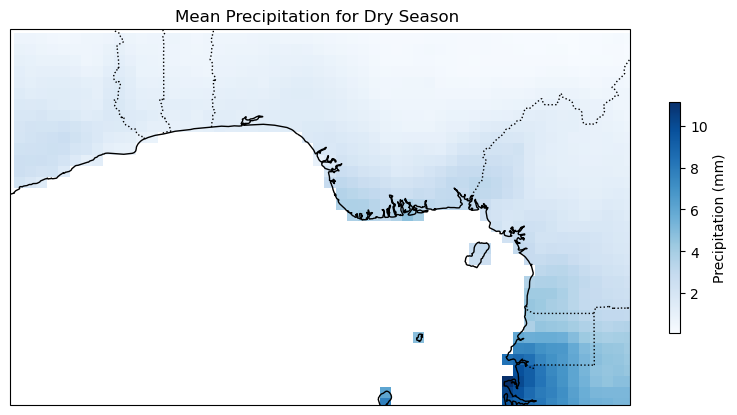

<Figure size 640x480 with 0 Axes>

In [82]:

mean_precipitation_dry = subset_data_dry['precip'].mean(dim='time')

# Create a plot
plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Add features to the plot
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the precipitation data
#precip_plot_wet = ax.pcolormesh(subset_data_wet['longitude'], subset_data['latitude'], mean_precipitation_wet, cmap='Blues', shading='auto')
precip_plot_dry = ax.pcolormesh(subset_data_dry['longitude'], subset_data['latitude'], mean_precipitation_dry, cmap='Blues', shading='auto')

# Add a colorbar
cbar = plt.colorbar(precip_plot_dry, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Precipitation (mm)')

# Add title and labels
ax.set_title('Mean Precipitation for Dry Season ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

plt.savefig('Mean_dryseason', format='png', dpi=300)



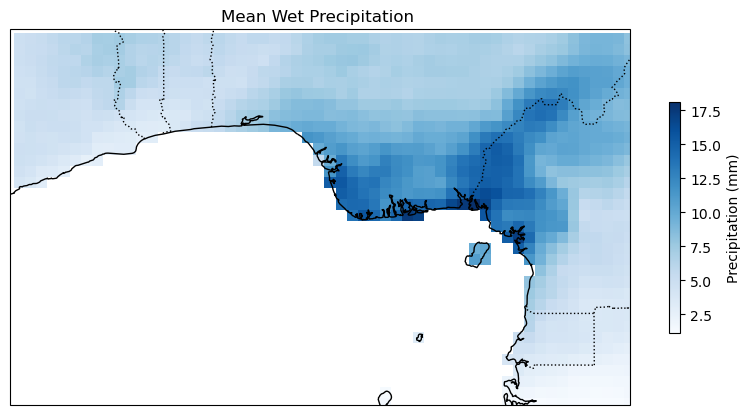

<Figure size 640x480 with 0 Axes>

In [89]:
mean_precipitation = subset_data['precip'].mean(dim='time')

# Create a plot
plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Add features to the plot
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the precipitation data
precip_plot = ax.pcolormesh(subset_data['longitude'], subset_data['latitude'], mean_precipitation, cmap='Blues', shading='auto')
precip_plot = ax.pcolormesh(subset_data['longitude'], subset_data['latitude'], mean_precipitation, cmap='Blues', shading='auto')

# Add a colorbar
cbar = plt.colorbar(precip_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Precipitation (mm)')

# Add title and labels
ax.set_title('Mean Wet Precipitation ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')



# Show the plot
plt.show()
plt.savefig('Mean_wwetseason', format='png', dpi=300)

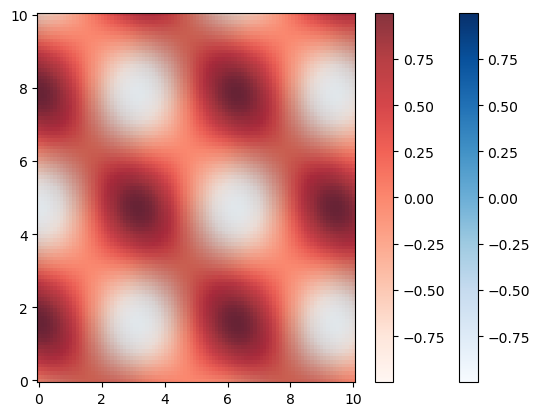

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)

Z1 = np.sin(X) * np.cos(Y)
Z2 = np.cos(X) * np.sin(Y)

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the first dataset
im1 = ax.pcolormesh(X, Y, Z1, cmap='Blues')

# Plot the second dataset with transparency
im2 = ax.pcolormesh(X, Y, Z2, cmap='Reds', alpha=0.8)  # Adjust alpha for transparency

# Colorbars
fig.colorbar(im1, ax=ax)
fig.colorbar(im2, ax=ax)

plt.show()

#Line Plots to visualize differences in mean precipitation betweeen the two seasons


/tmp/ipykernel_2835/1567113389.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


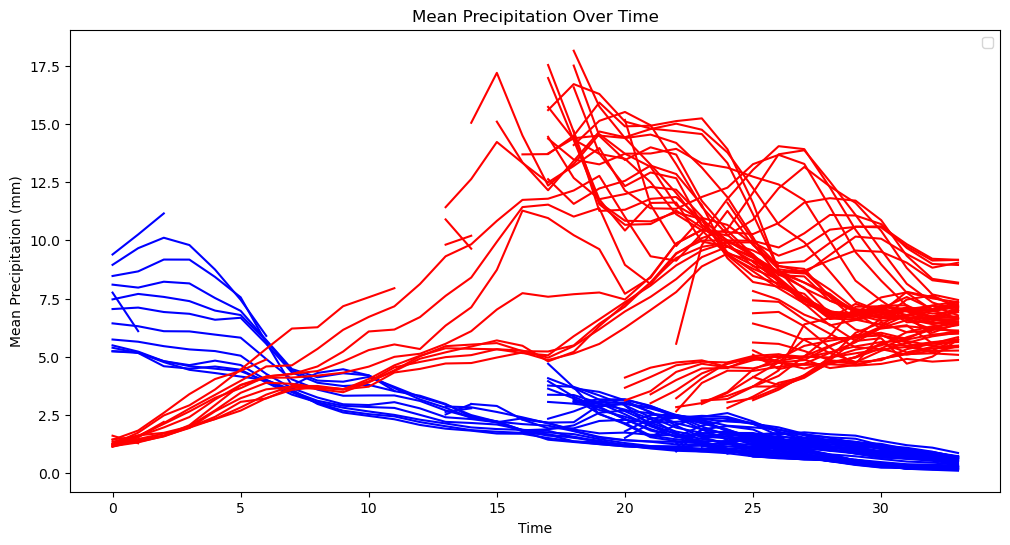

In [78]:
plt.figure(figsize=(12, 6))

# Plot the first time slice
plt.plot(mean_precipitation_dry, color='blue')

# Plot the second time slice
plt.plot(mean_precipitation_wet, color='red')

# Adding titles and labels
plt.title('Mean Precipitation Over Time')
plt.xlabel('Time')
plt.ylabel('Mean Precipitation (mm)')
plt.legend()

# Show the plot
plt.show()